In [23]:
import os
import torch
import numpy as np
from PIL import Image
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops
from segment_anything_hq import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [24]:
SAM_CHECKPOINT = "/scratch/gpfs/eh0560/segment-anything/sam_models/sam_hq_vit_h.pth"
MODEL_TYPE = "vit_h"

DINO_MODEL_PATH = "/scratch/gpfs/eh0560/GroundingDINO/models/groundingdino_swinb_cogcoor.pth"
DINO_CONFIG_PATH = "/scratch/gpfs/eh0560/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py"

DEVICE = "cuda"
IMAGES_DIR = "/scratch/gpfs/RUSTOW/deskewing_datasets/images/cudl_images/images_62"

TEXT_PROMPT = "scanned document"
BOX_THRESHOLD = 0.45
TEXT_THRESHOLD = 0.25

In [25]:
def load_sam_model(checkpoint, model_type, device):
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    return sam.to(device), SamPredictor(sam)

def get_image_from_path(images_dir):
    image_paths = [os.path.join(images_dir, path) for path in os.listdir(images_dir)]
    return image_paths[23]

In [26]:
image_path = get_image_from_path(IMAGES_DIR)

In [27]:
sam_model, sam_predictor = load_sam_model(SAM_CHECKPOINT, MODEL_TYPE, DEVICE)

<All keys matched successfully>


In [28]:
dino_model = load_model(DINO_CONFIG_PATH, DINO_MODEL_PATH)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
image_source, image = load_image(image_path)
boxes, logits, phrases = predict(dino_model, image, TEXT_PROMPT, BOX_THRESHOLD, TEXT_THRESHOLD)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]

In [30]:
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=dino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1]

In [31]:
sam_predictor.set_image(image_source)
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

In [ ]:
def visualize_mask(mask, image, random_color=True):
    mask = mask.cpu() if mask.is_cuda else mask
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0) if random_color else np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.numpy() * 255).astype(np.uint8)).convert("RGBA")
    
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [32]:
annotated_frame_with_mask = visualize_mask(masks[0][0], annotated_frame)

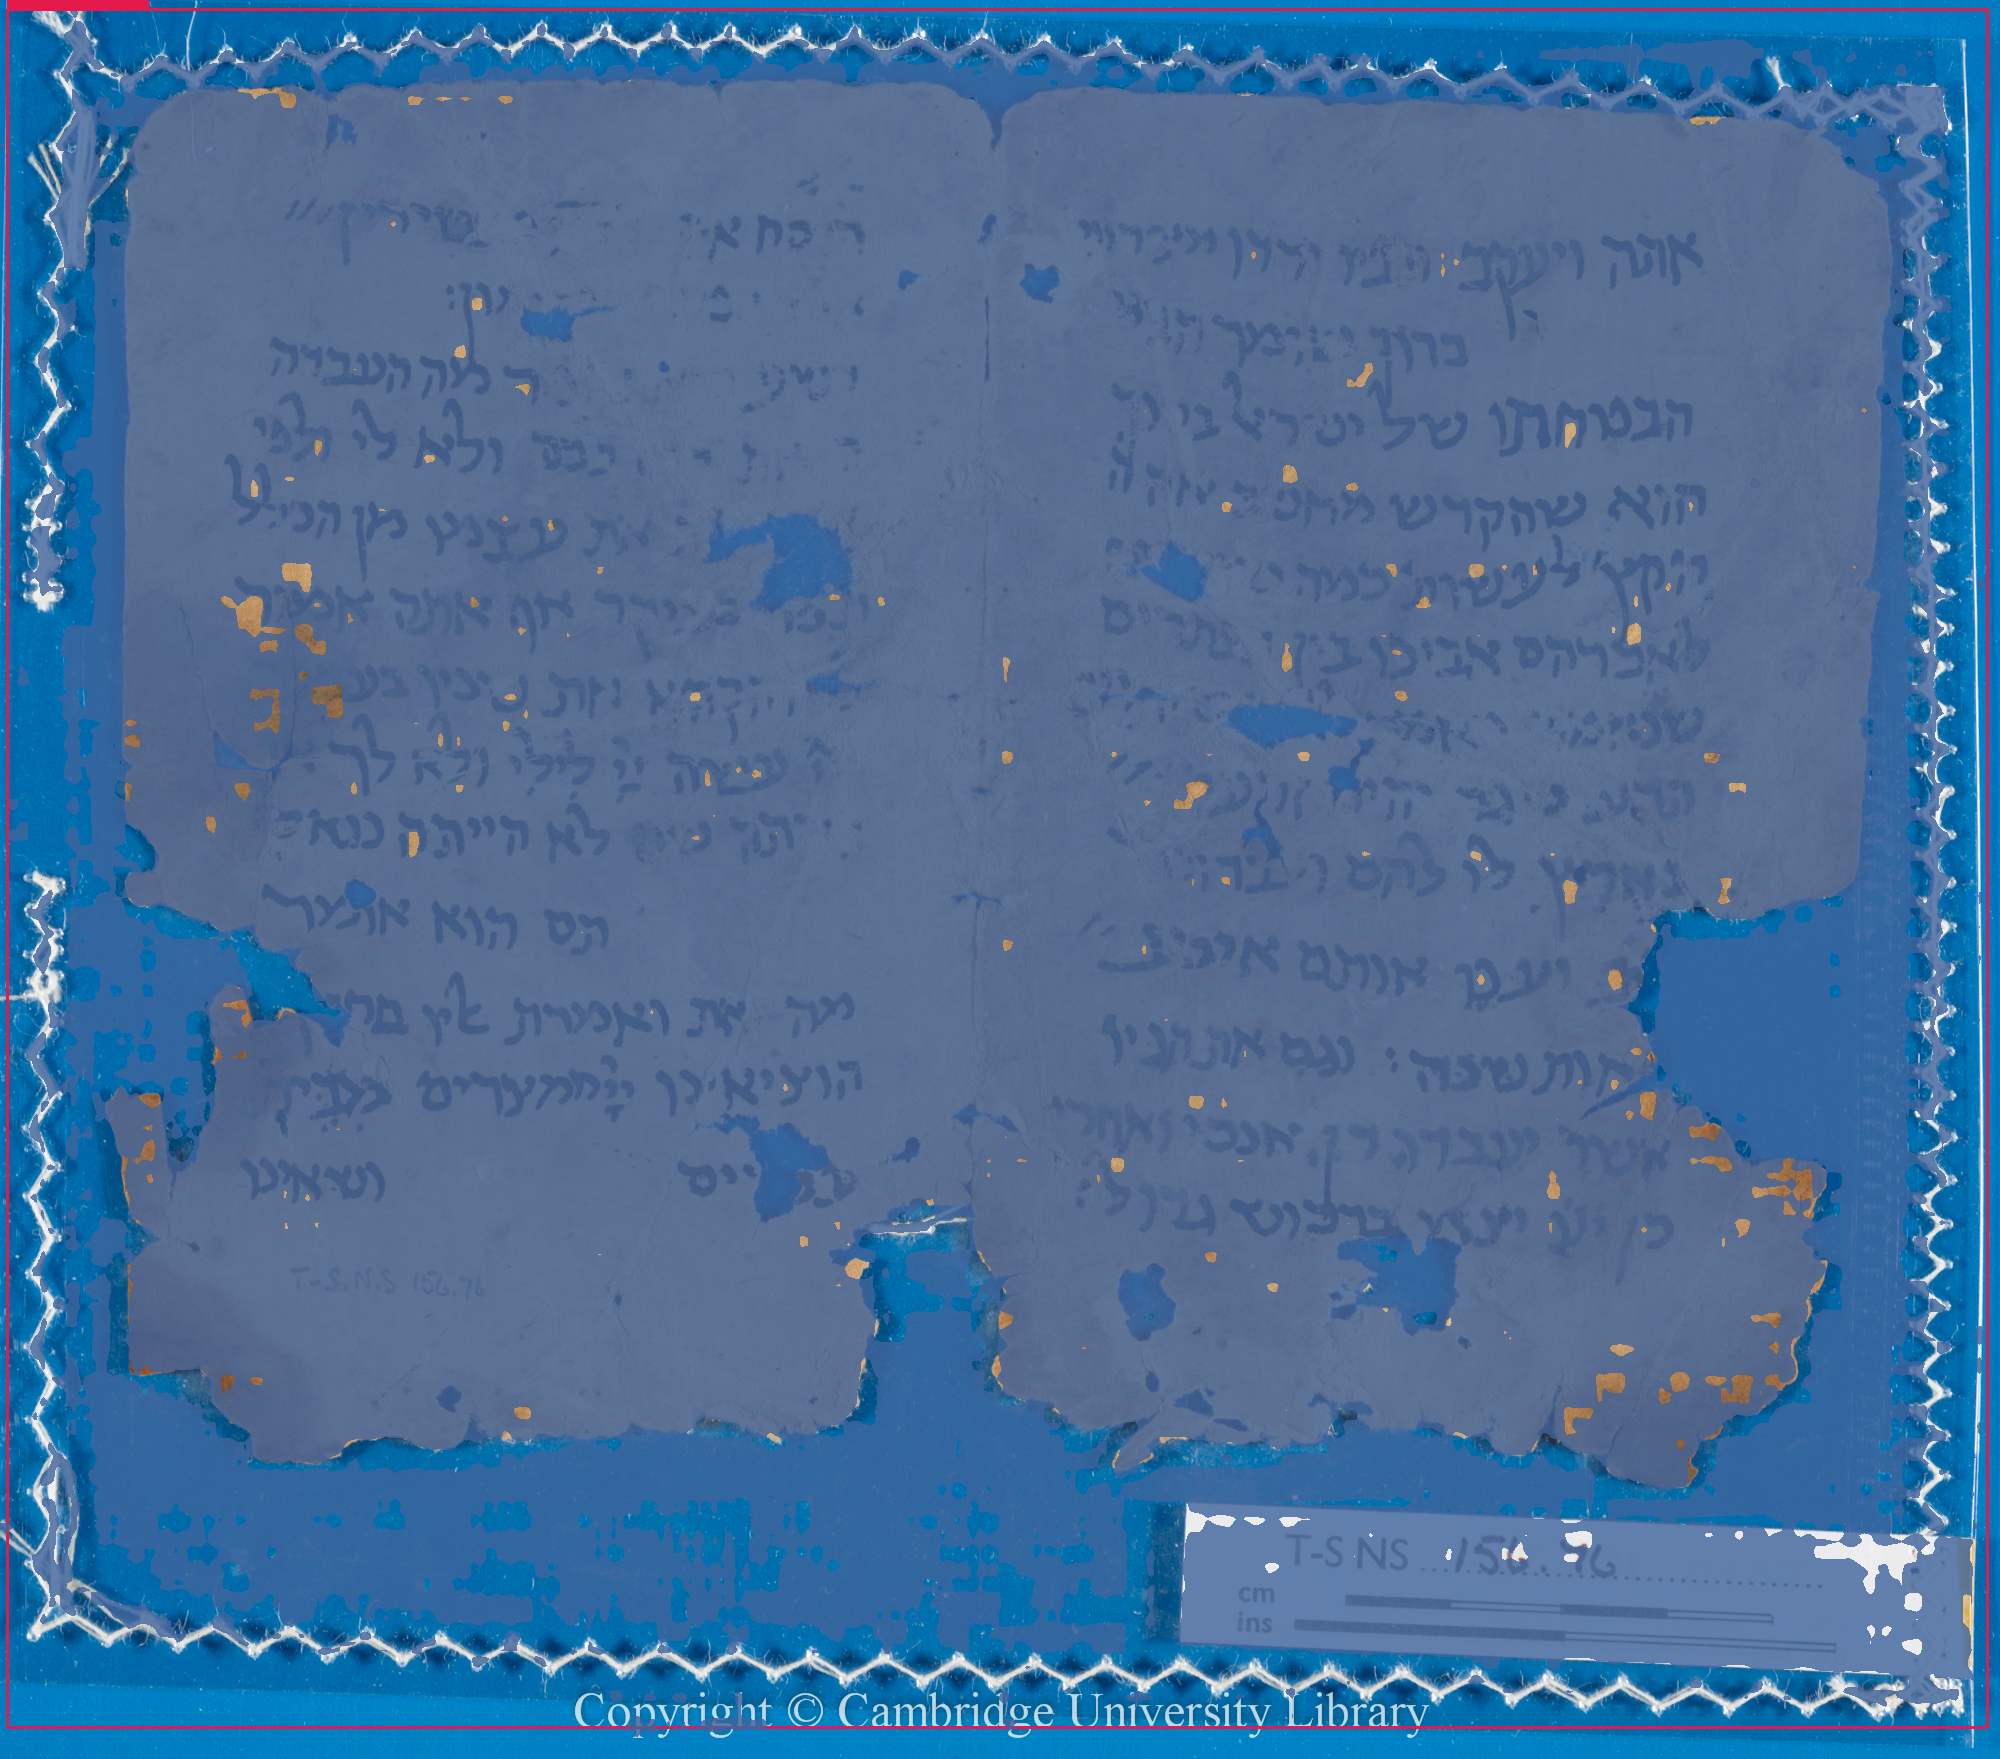

In [33]:
Image.fromarray(annotated_frame_with_mask)